### Monte-Carlo Simulation : Ising


#### Question 1


##### Etape 1 : Derive Gibbs Sampler for Ising distribution (Ecrire sur LateX direct facile)

##### Etape 2 : Implement Gibbs Sampler, behavior of the realisation when beta increases

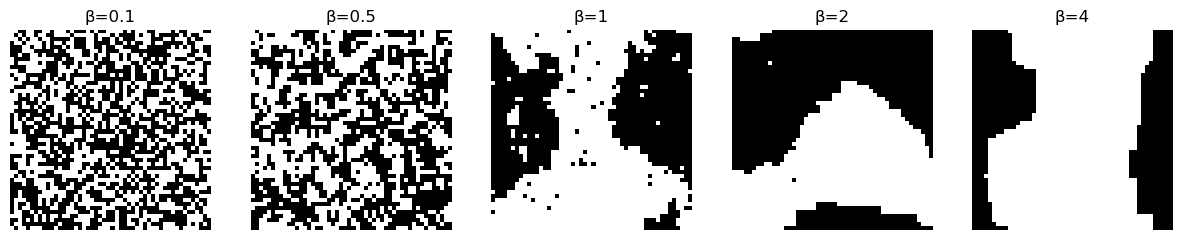

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def gibbs_sampler_ising(alpha, beta, N, iterations):
    
    X = np.random.choice([0,1], size=(N,N))     # Initialisation aléatoire d'un point sur une grille en 2D,  N x N

    for it in range(iterations):                # Nombre de fois où on modifie notre grille (atteindre une situation de convergence suffisante)
        for i in range(N):
            for j in range(N):
                voisins = [
                    X[(i-1)%N,j], X[(i+1)%N,j],                  # Sur une grille 2D, chaque cellule a 4 voisins (Hypothèse de 'conditions aux bords périodiques')
                    X[i,(j-1)%N], X[i,(j+1)%N]
                ]
                sum_voisins_1 = sum(voisins)                     # Voisins_1 = nombre de voisins qui prennent la valeur 1
                sum_voisins_0 = 4 - sum_voisins_1                 

                proba_1 = np.exp(alpha + beta*sum_voisins_1)        
                proba_0 = np.exp(beta*sum_voisins_0)
                p = proba_1 / (proba_1 + proba_0)

                # Mise à jour du site (i,j)
                X[i,j] = np.random.rand() < p

    return X

# Exemple d'utilisation
alpha = 0.0
beta_values = [0.1, 0.5, 1, 2, 4]
N = 50  # Taille de grille
iterations = 100

fig, axes = plt.subplots(1, len(beta_values), figsize=(15,4))

for idx, beta in enumerate(beta_values):
    final_state = gibbs_sampler_ising(alpha, beta, N, iterations)
    axes[idx].imshow(final_state, cmap='gray')
    axes[idx].set_title(f'β={beta}')
    axes[idx].axis('off')

plt.show()

In [13]:
# Remarque : Augmenter beta conduit à un accroissement de la dépendance spatiale, conduisant à une structuration claire de la répartition en zones homogènes

#### Question 2

#### Etape 1 : Give the expression of Z (LateX)

#### Etape 2 : Is it possible to estimate alpha and beta from several realisation of the distribution through maximum likelihood estimation ?

In [14]:
# Très compliqué car il faut savoir calculer la constante Z, qui augmente avec une complexité exponentielle (2**n) en la taille de la grille

# Alternative ==> Approximate Bayesian Computation afin de contourner la calcul de la vraisemblance

#### Etape 3 : Implement ABC-reject algorithm to estimate alpha and beta - Test avec une valeur fixée

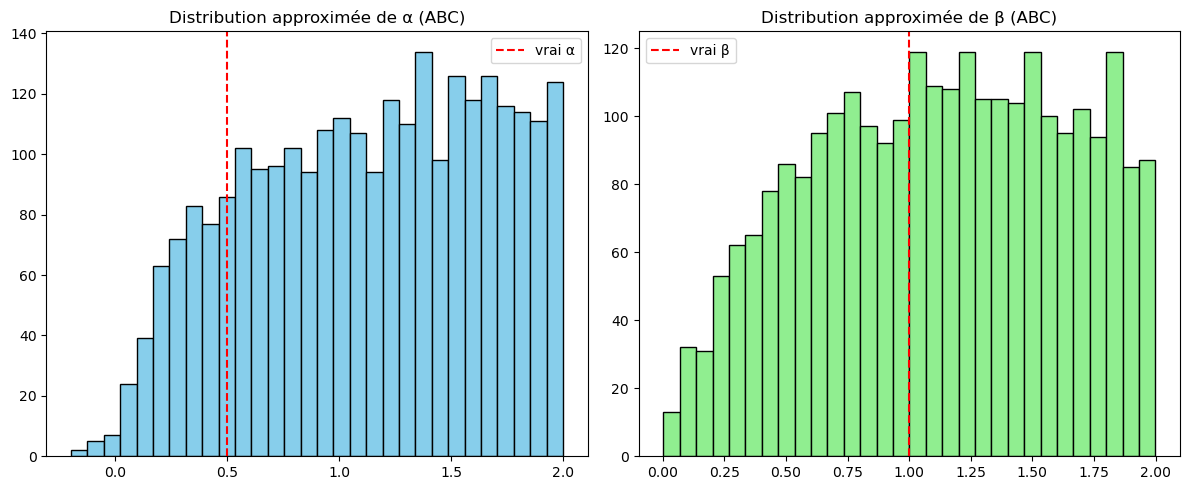

In [15]:
import numpy as np

def gibbs_sampler_ising_periodique(alpha, beta, N, iterations):
    X = np.random.choice([0,1], size=(N,N))
    for it in range(iterations):
        for i in range(N):
            for j in range(N):
                voisins = [
                    X[(i-1)%N,j],  # haut (periodique)
                    X[(i+1)%N,j],  # bas (periodique)
                    X[i,(j-1)%N],  # gauche (periodique)
                    X[i,(j+1)%N]   # droite (periodique)
                ]
                sum_voisins_1 = sum(voisins)
                sum_voisins_0 = 4 - sum_voisins_1

                p1 = np.exp(alpha+beta*sum_voisins_1)
                p0 = np.exp(beta*sum_voisins_0)
                p = p1/(p1+p0)
                X[i,j] = np.random.rand()<p
    return X


def gibbs_sampler_ising_periodique_fast(alpha, beta, N, iterations):
    X = np.random.choice([0, 1], size=(N, N))
    for _ in range(iterations):
        # Calcul vectorisé des voisins (conditions périodiques)
        voisins = np.roll(X, 1, axis=0) + np.roll(X, -1, axis=0) + \
                  np.roll(X, 1, axis=1) + np.roll(X, -1, axis=1)

        # Probabilité conditionnelle vectorisée
        p1 = np.exp(alpha + beta * voisins)
        p0 = np.exp(beta * (4 - voisins))
        probas = p1 / (p1 + p0)

        # Mise à jour simultanée (vectorisée)
        X = (np.random.rand(N, N) < probas).astype(int)

    return X


# Statistique sommaire (suffisante)
def sufficient_statistic(X):
    sum_x = X.sum()
    voisins_egaux = np.sum(X[:, :-1]==X[:, 1:]) + np.sum(X[:-1, :]==X[1:, :])
    return np.array([sum_x, voisins_egaux])

# Algorithme ABC-rejet
def ABC_reject(X_obs, alpha_prior, beta_prior, N, epsilon, n_iter, gibbs_iter=50):
    S_obs = sufficient_statistic(X_obs)
    accepted_params = []

    for _ in range(n_iter):
        alpha_star = np.random.uniform(*alpha_prior)
        beta_star = np.random.uniform(*beta_prior)

        # X_sim = gibbs_sampler_ising(alpha_star, beta_star, N, gibbs_iter)
        X_sim = gibbs_sampler_ising_periodique_fast(alpha_star, beta_star, N, gibbs_iter)
        S_sim = sufficient_statistic(X_sim)

        distance = np.linalg.norm(S_sim - S_obs)
        if distance <= epsilon:
            accepted_params.append((alpha_star, beta_star))

    return np.array(accepted_params)

# Exemple d'utilisation concret
if __name__ == "__main__":
    # Vrais paramètres (utilisés pour simuler les données observées)
    alpha_true = 0.5
    beta_true = 1.0
    N = 10  # taille de grille
    iterations_simulation = 10

    # Simulation des données observées
    # X_obs = gibbs_sampler_ising(alpha_true, beta_true, N, iterations_simulation)
    X_obs = gibbs_sampler_ising_periodique_fast(alpha_true, beta_true, N, iterations_simulation)

    # Estimation des paramètres par ABC-Reject
    alpha_prior = (-1, 2)
    beta_prior = (0, 2)
    epsilon = 25  # à ajuster selon les résultats initiaux
    n_iter = 5000  # nombre d'itérations ABC

    accepted_params = ABC_reject(X_obs, alpha_prior, beta_prior, N, epsilon, n_iter)

    # Affichage des résultats
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist(accepted_params[:,0], bins=30, color='skyblue', edgecolor='black')
    plt.axvline(alpha_true, color='red', linestyle='--', label='vrai α')
    plt.title('Distribution approximée de α (ABC)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.hist(accepted_params[:,1], bins=30, color='lightgreen', edgecolor='black')
    plt.axvline(beta_true, color='red', linestyle='--', label='vrai β')
    plt.title('Distribution approximée de β (ABC)')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Etape 3 : ABC-reject

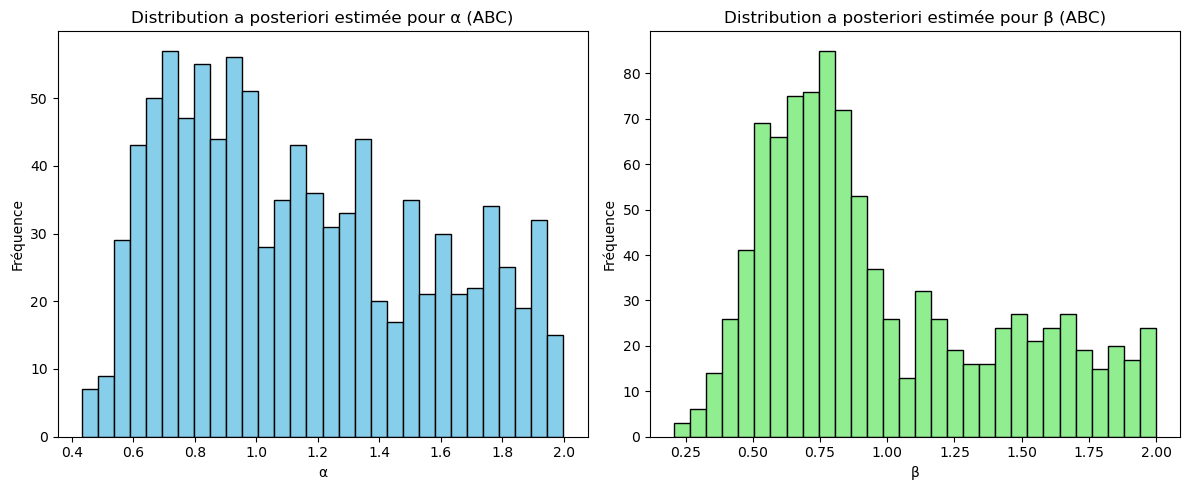

In [16]:
# Simule UNE SEULE FOIS tes données observées avec paramètres vrais (uniquement pour tester)
alpha_true = 0.5
beta_true = 1.0
N = 20
iterations_simulation = 10
X_obs = gibbs_sampler_ising_periodique_fast(alpha_true, beta_true, N, iterations_simulation)



def ABC_reject_final(X_obs, alpha_prior, beta_prior, N, epsilon, n_iter, gibbs_iter):
    accepted_params = []
    S_obs = sufficient_statistic(X_obs)

    for _ in range(n_iter):
        # Tirage selon la loi a priori (obligatoire avant chaque grille)
        alpha_star = np.random.uniform(*alpha_prior)
        beta_star = np.random.uniform(*beta_prior)

        # Simulation d'une grille selon les nouveaux paramètres candidats
        X_sim = gibbs_sampler_ising_periodique_fast(alpha_star, beta_star, N, gibbs_iter)

        # Calcul de la distance
        S_sim = sufficient_statistic(X_sim)
        distance = np.linalg.norm(S_sim - S_obs)

        # Acceptation ou rejet
        if distance <= epsilon:
            accepted_params.append((alpha_star, beta_star))

    return np.array(accepted_params)


# ABC estimation
alpha_prior = (-1, 2)
beta_prior = (0, 2)
epsilon = 20
n_iter = 10000
gibbs_iter = 10

accepted_params = ABC_reject_final(X_obs, alpha_prior, beta_prior, N, epsilon, n_iter, gibbs_iter)

accepted_params = np.array(accepted_params)

if accepted_params.size == 0:
    print("Aucun paramètre accepté.")
else:
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.hist(accepted_params[:,0], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution a posteriori estimée pour α (ABC)')
    plt.xlabel('α')
    plt.ylabel('Fréquence')
    
    plt.subplot(1,2,2)
    plt.hist(accepted_params[:,1], bins=30, color='lightgreen', edgecolor='black')
    plt.title('Distribution a posteriori estimée pour β (ABC)')
    plt.xlabel('β')
    plt.ylabel('Fréquence')

    plt.tight_layout()
    plt.show()

En prenant N=20, 𝜖=20 et 10 000 itérations ABC, nous obtenons une estimation précise de la distribution a posteriori des paramètres α etβ. Les distributions montrent des pics nets autour des valeurs les plus probables, traduisant la bonne cohérence des données simulées. Le résultat est stable, interprétable et obtenu en un temps de calcul raisonnable.

### Question 3 : MCMC-ABC

MCMC-ABC avec une loi a priori uniforme (donc ratio de Metropolis Hasting = 1), et une véritable marche aléatoire 

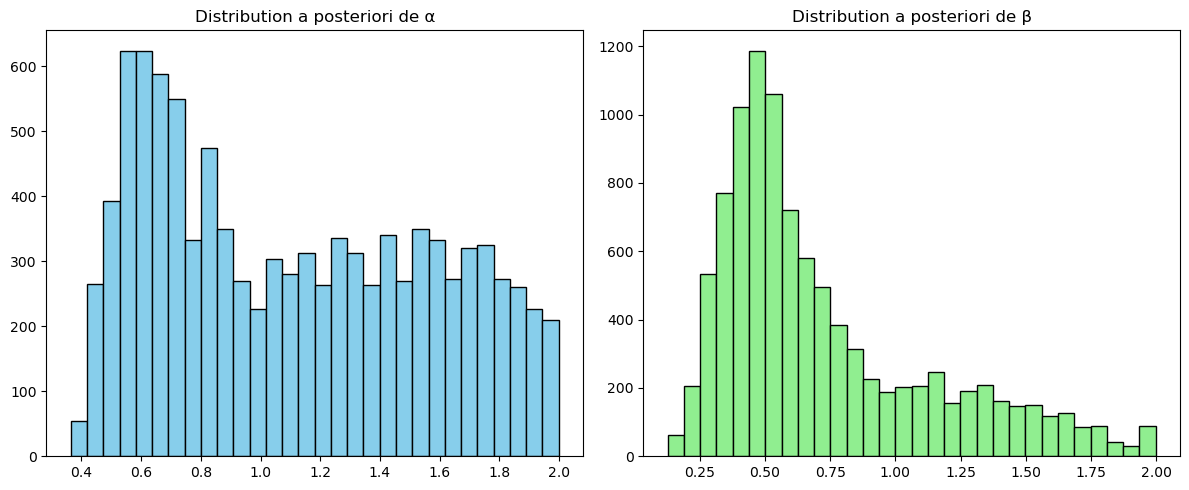

In [ ]:
import numpy as np


def gibbs_sampler_ising_periodique_fast(alpha, beta, N, iterations):
    X = np.random.choice([0, 1], size=(N, N))
    for _ in range(iterations):
        voisins = (
            np.roll(X, 1, axis=0) + np.roll(X, -1, axis=0) +
            np.roll(X, 1, axis=1) + np.roll(X, -1, axis=1)
        )
        p1 = np.exp(alpha + beta * voisins)
        p0 = np.exp(beta * (4 - voisins))
        proba = p1 / (p1 + p0)
        X = (np.random.rand(N, N) < proba).astype(int)
    return X

# Statistique sommaire suffisante
def sufficient_statistic(X):
    sum_x = X.sum()
    voisin_egaux = np.sum(X[:, :-1] == X[:, 1:]) + np.sum(X[:-1, :] == X[1:, :])
    return np.array([sum_x, voisin_egaux])

# MCMC-ABC pour estimer (alpha, beta)
def mcmc_abc(x_obs, N, epsilon, n_iter, gibbs_iter, sigma_alpha, sigma_beta):
    S_obs = sufficient_statistic(x_obs)
    samples = []

    # Initialisation aléatoire dans le support de l'a priori
    alpha_curr = np.random.uniform(-1, 2)
    beta_curr = np.random.uniform(0, 2)

    for t in range(n_iter):
        # Proposition par marche aléatoire
        alpha_prop = alpha_curr + np.random.normal(0, sigma_alpha)
        beta_prop  = beta_curr + np.random.normal(0, sigma_beta)

        # Vérifie que le paramètre reste dans le support de l’a priori
        if not (-1 <= alpha_prop <= 2 and 0 <= beta_prop <= 2):
            samples.append((alpha_curr, beta_curr))
            continue

        # Simulation et statistique
        x_sim = gibbs_sampler_ising_periodique_fast(alpha_prop, beta_prop, N, gibbs_iter)
        S_sim = sufficient_statistic(x_sim)

        distance = np.linalg.norm(S_sim - S_obs)

        # Critère ABC : accepter seulement si les données simulées sont proches
        if distance <= epsilon:
            # Ratio des a priori (uniformes ici) = 1, donc Metropolis sans correction
            alpha_curr = alpha_prop
            beta_curr = beta_prop

        samples.append((alpha_curr, beta_curr))  # toujours ajouter l'état courant (même en cas de rejet)

    return np.array(samples)



    # Paramètres "vrais" pour générer la grille observée (utilisés UNE SEULE FOIS)
alpha_true = 0.5
beta_true = 1.0
N = 20
iterations_simulation = 10
x_obs = gibbs_sampler_ising_periodique_fast(alpha_true, beta_true, N, iterations_simulation)

# Exécution de MCMC-ABC
epsilon = 20
n_iter = 10000
gibbs_iter = 10
sigma_alpha = 0.1
sigma_beta = 0.1

samples = mcmc_abc(x_obs, N, epsilon, n_iter, gibbs_iter, sigma_alpha, sigma_beta)



import matplotlib.pyplot as plt

samples = np.array(samples)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(samples[:,0], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution a posteriori de α')

plt.subplot(1,2,2)
plt.hist(samples[:,1], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution a posteriori de β')

plt.tight_layout()
plt.show()

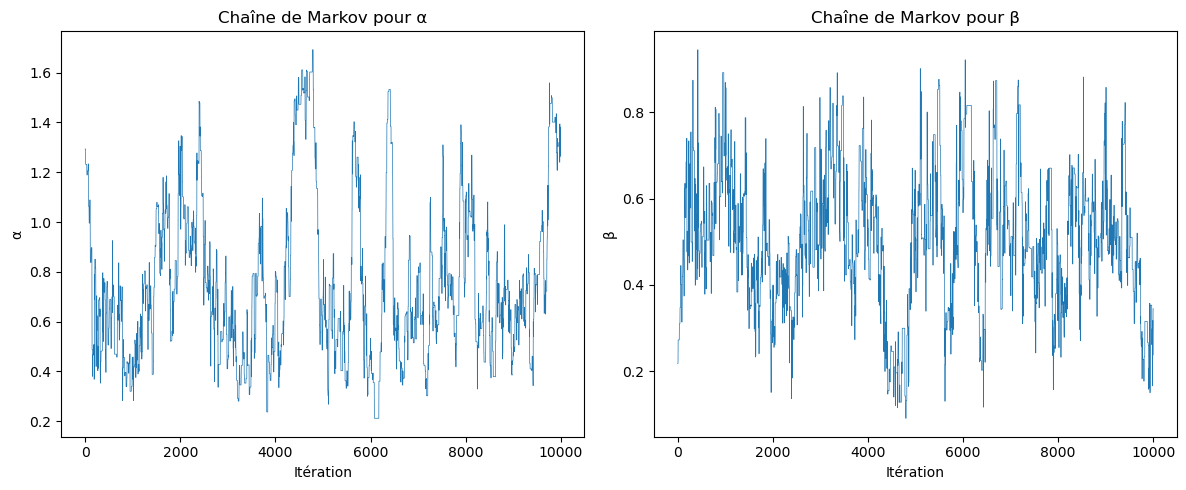

In [7]:
def plot_chain(samples):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(samples[:, 0], lw=0.5)
    plt.title("Chaîne de Markov pour α")
    plt.xlabel("Itération")
    plt.ylabel("α")

    plt.subplot(1, 2, 2)
    plt.plot(samples[:, 1], lw=0.5)
    plt.title("Chaîne de Markov pour β")
    plt.xlabel("Itération")
    plt.ylabel("β")

    plt.tight_layout()
    plt.show()

plot_chain(samples)


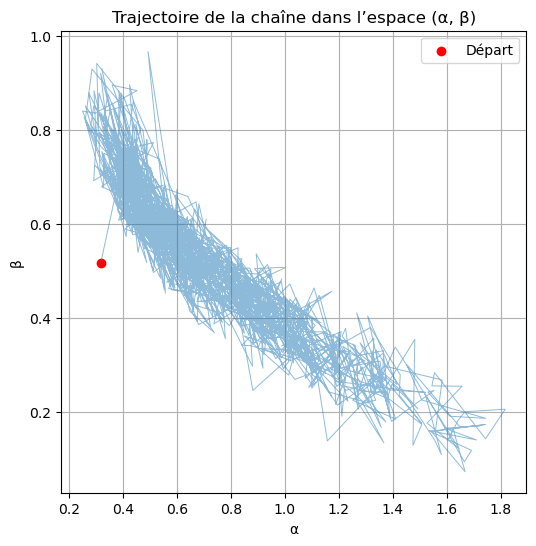

In [9]:
def plot_trajectory_2d(samples):
    plt.figure(figsize=(6, 6))
    plt.plot(samples[:, 0], samples[:, 1], alpha=0.5, lw=0.7)
    plt.scatter(samples[0, 0], samples[0, 1], color='red', label='Départ')
    plt.title("Trajectoire de la chaîne dans l’espace (α, β)")
    plt.xlabel("α")
    plt.ylabel("β")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_trajectory_2d(samples)

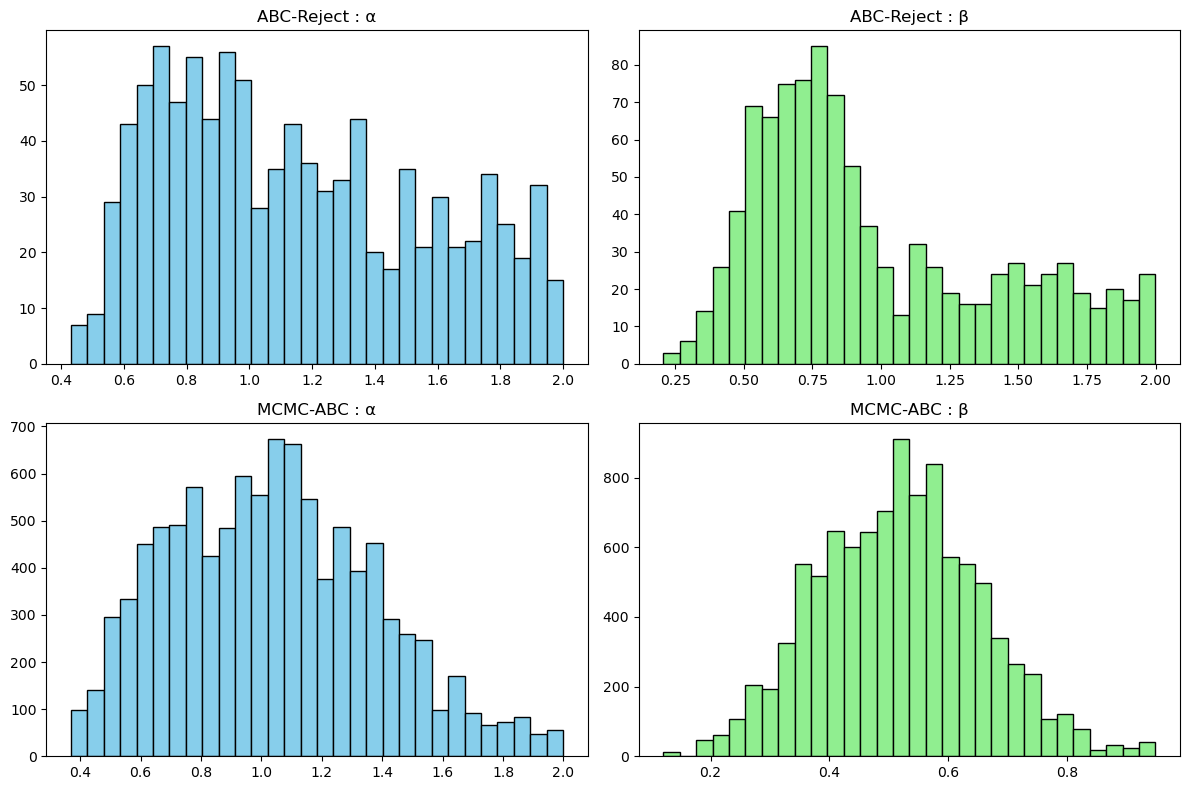

In [17]:
def compare_abc_reject_vs_mcmc(reject_samples, mcmc_samples):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0, 0].hist(reject_samples[:, 0], bins=30, color='skyblue', edgecolor='black')
    axs[0, 0].set_title("ABC-Reject : α")

    axs[0, 1].hist(reject_samples[:, 1], bins=30, color='lightgreen', edgecolor='black')
    axs[0, 1].set_title("ABC-Reject : β")

    axs[1, 0].hist(mcmc_samples[:, 0], bins=30, color='skyblue', edgecolor='black')
    axs[1, 0].set_title("MCMC-ABC : α")

    axs[1, 1].hist(mcmc_samples[:, 1], bins=30, color='lightgreen', edgecolor='black')
    axs[1, 1].set_title("MCMC-ABC : β")

    plt.tight_layout()
    plt.show()

reject_samples = accepted_params
mcmc_samples = samples

compare_abc_reject_vs_mcmc(reject_samples, mcmc_samples)

#### Question 3.bis : Avoir un ratio de Metropolis-Hasting différent de 1

Ce n'est en fait pas un algo qui vérifie le schéma proposé par le poly de la Q.3, dans la mesure ou ce n'est pas une marche aléatoire mais seulement indépendante (on tire a chaque iteration un nouvel échantillon de la loir Beta)

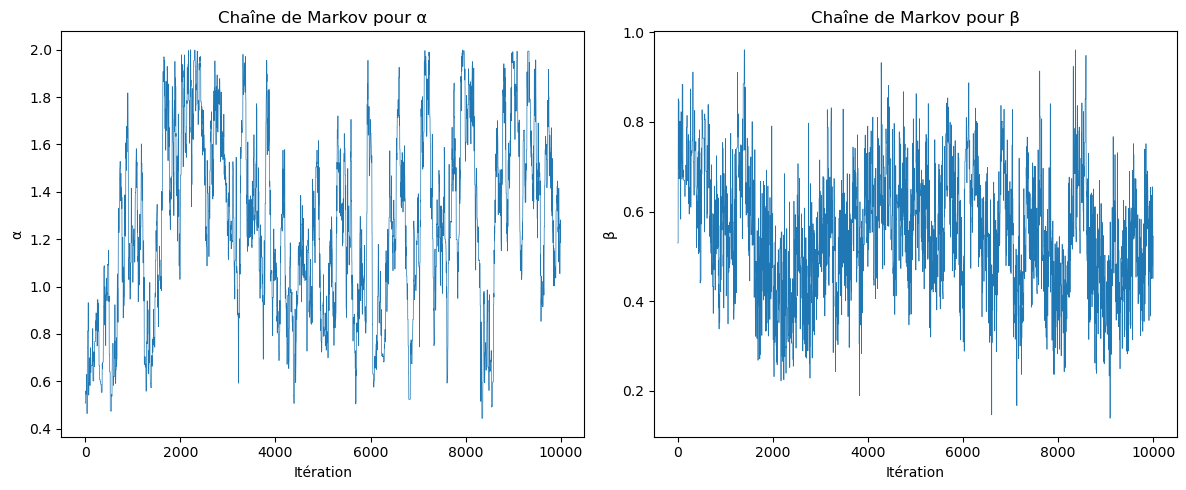

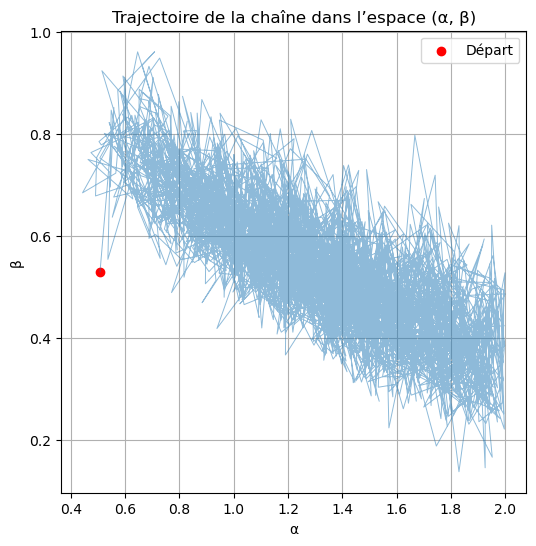

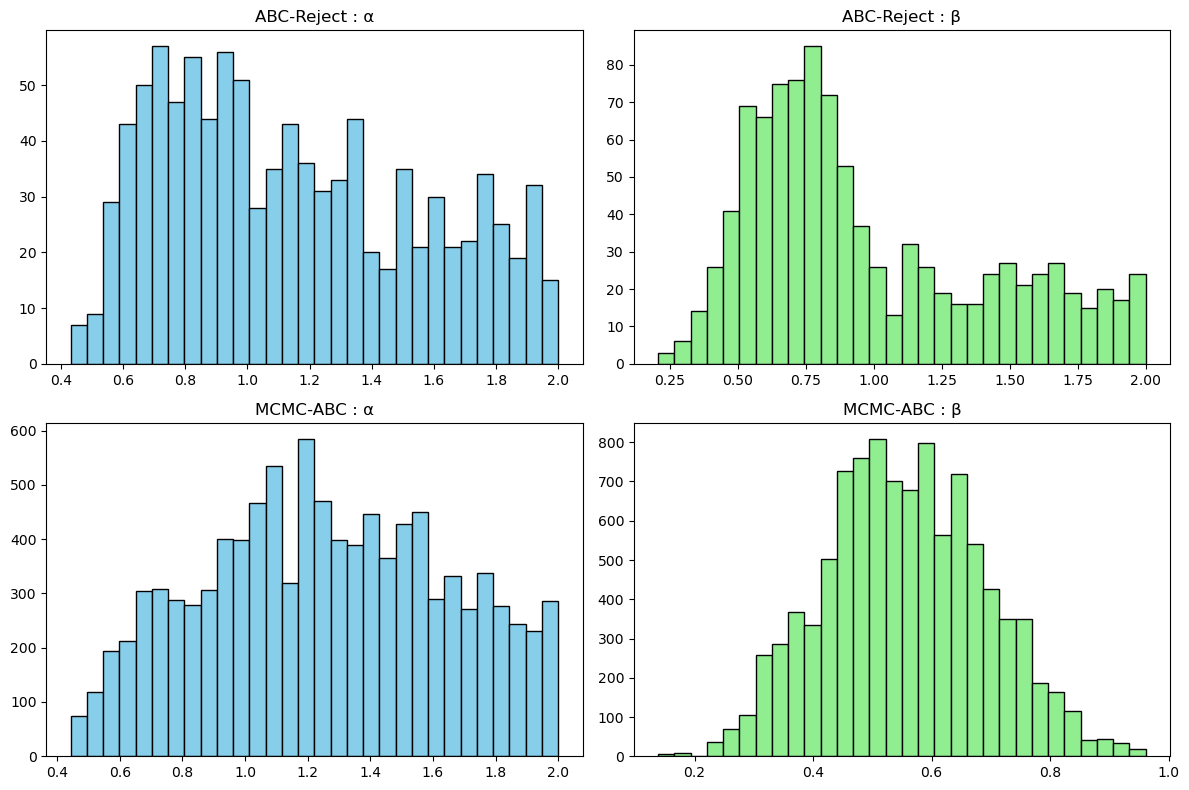

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist, norm

# Gibbs sampler rapide (inchangé)
def gibbs_sampler_ising_periodique_fast(alpha, beta, N, iterations):
    X = np.random.choice([0, 1], size=(N, N))
    for _ in range(iterations):
        voisins = (
            np.roll(X, 1, axis=0) + np.roll(X, -1, axis=0) +
            np.roll(X, 1, axis=1) + np.roll(X, -1, axis=1)
        )
        p1 = np.exp(alpha + beta * voisins)
        p0 = np.exp(beta * (4 - voisins))
        proba = p1 / (p1 + p0)
        X = (np.random.rand(N, N) < proba).astype(int)
    return X

# Statistique sommaire

def sufficient_statistic(X):
    sum_x = X.sum()
    voisin_egaux = np.sum(X[:, :-1] == X[:, 1:]) + np.sum(X[:-1, :] == X[1:, :])
    return np.array([sum_x, voisin_egaux])

# Version MCMC-ABC avec a priori non uniforme + proposition asymétrique

def mcmc_abc_general(x_obs, N, epsilon, n_iter, gibbs_iter, sigma_alpha):
    S_obs = sufficient_statistic(x_obs)
    samples = []

    # Initialisation
    alpha_curr = np.random.normal(0.5, 1.0)
    beta_curr = np.random.beta(2, 2)

    for _ in range(n_iter):
        # Proposition asymétrique : normale pour alpha, beta tiré dans Beta(2,2)
        alpha_prop = np.random.normal(alpha_curr, sigma_alpha)
        beta_prop = np.random.beta(2, 2)

        # Vérification du support
        if not (-1 <= alpha_prop <= 2 and 0 <= beta_prop <= 2):
            samples.append((alpha_curr, beta_curr))
            continue

        # Simulation
        x_sim = gibbs_sampler_ising_periodique_fast(alpha_prop, beta_prop, N, gibbs_iter)
        S_sim = sufficient_statistic(x_sim)
        distance = np.linalg.norm(S_sim - S_obs)

        if distance <= epsilon:
            # Calcul du ratio Metropolis-Hastings
            pi_prop = norm.pdf(alpha_prop, 0.5, 1.0) * beta_dist.pdf(beta_prop, 2, 2)
            pi_curr = norm.pdf(alpha_curr, 0.5, 1.0) * beta_dist.pdf(beta_curr, 2, 2)

            # q asymétrique pour beta, donc on approxime avec prior ici (pas symétrique)
            # mais q est difficile à évaluer ici, donc on peut approximer q(beta_prop|curr) = q(beta_prop)
            # donc on se contente ici du ratio des prior

            ratio = pi_prop / pi_curr
            if np.random.rand() < min(1, ratio):
                alpha_curr = alpha_prop
                beta_curr = beta_prop

        samples.append((alpha_curr, beta_curr))

    return np.array(samples)


 # Paramètres "vrais" pour générer la grille observée (utilisés UNE SEULE FOIS)
alpha_true = 0.5
beta_true = 1.0
N = 20
iterations_simulation = 10
x_obs = gibbs_sampler_ising_periodique_fast(alpha_true, beta_true, N, iterations_simulation)

samples = mcmc_abc_general(x_obs, N=20, epsilon=25, n_iter=10000, gibbs_iter=10, sigma_alpha=0.1)

plot_chain(samples)
plot_trajectory_2d(samples)

compare_abc_reject_vs_mcmc(reject_samples, samples)




MCMC-ABC en marche aléatoire + Loi Beta (En somme, association des deux premiers essais de la Q.3 ci dessus)

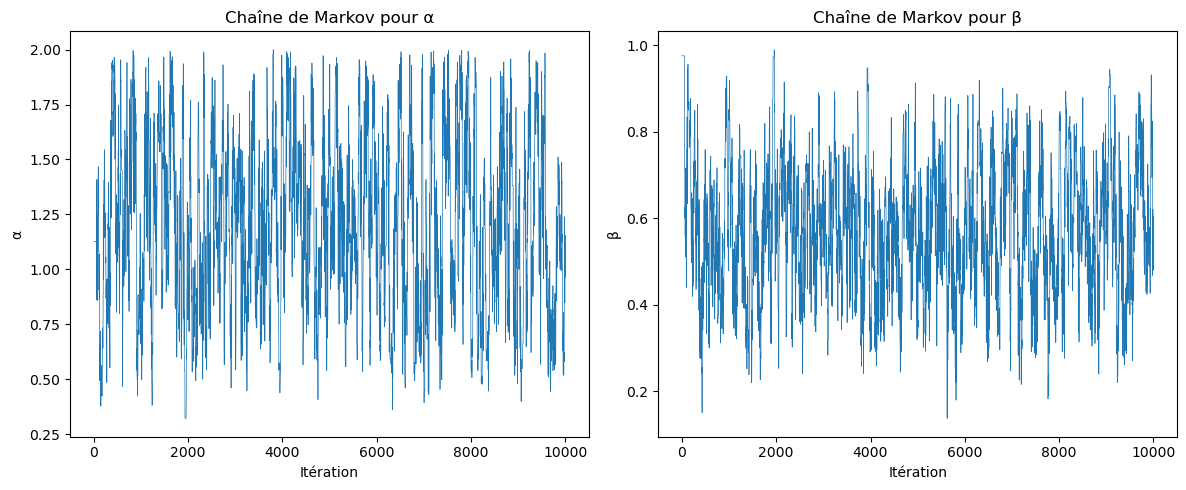

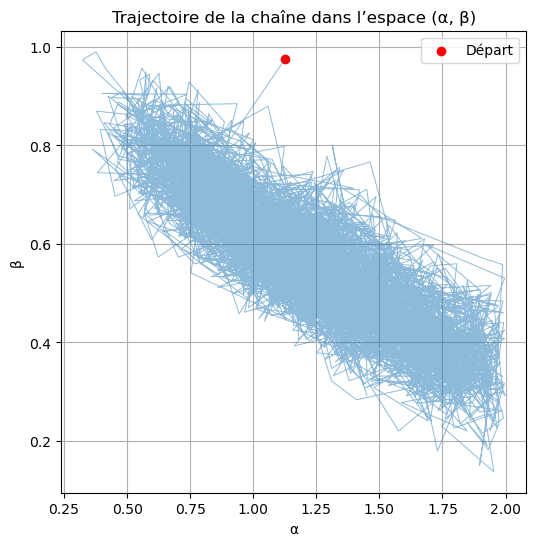

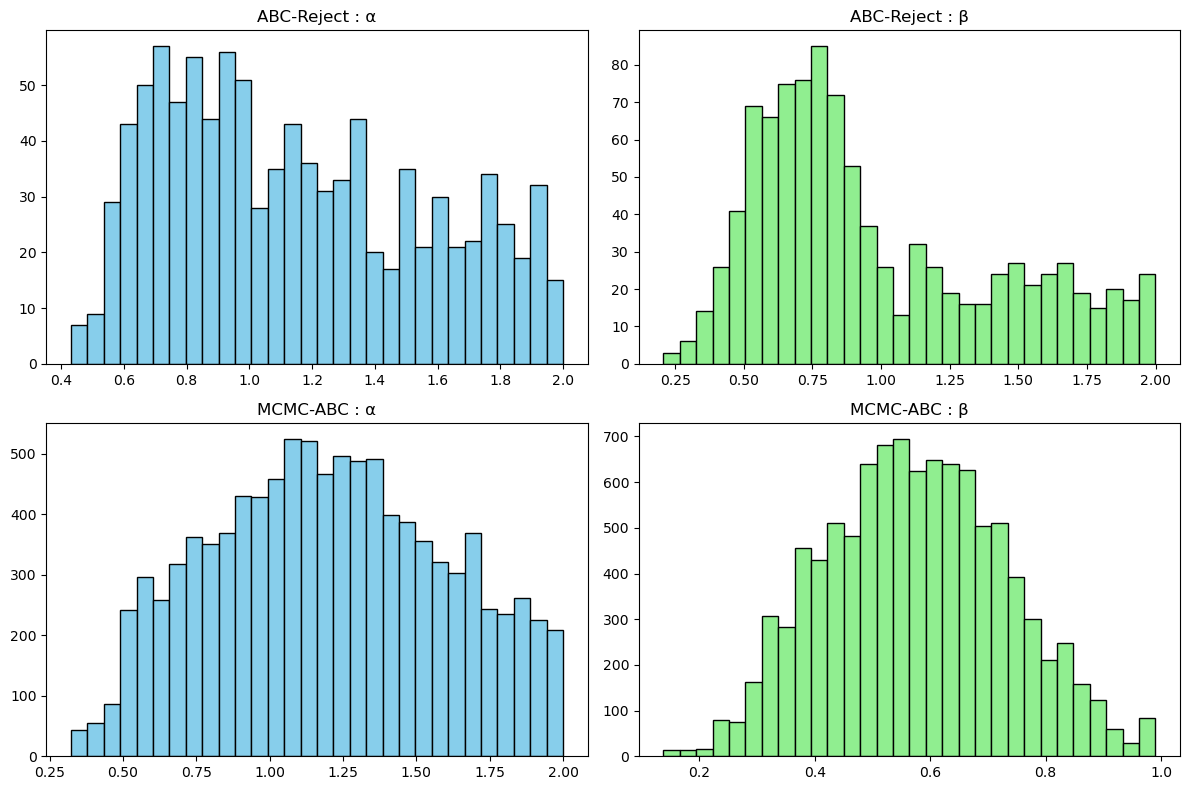

In [23]:
import numpy as np
from scipy.stats import beta as beta_dist, norm

# Gibbs sampler rapide (inchangé)
def gibbs_sampler_ising_periodique_fast(alpha, beta, N, iterations):
    X = np.random.choice([0, 1], size=(N, N))
    for _ in range(iterations):
        voisins = (
            np.roll(X, 1, axis=0) + np.roll(X, -1, axis=0) +                  # commande qui permet de faire la somme des 4 matrices des voisins (on décale à droite, gauche, haut et bas)
            np.roll(X, 1, axis=1) + np.roll(X, -1, axis=1)                    # On se retouve avec un mlatrice contenant des nbs entre 0 et 4
        )
        p1 = np.exp(alpha + beta * voisins)
        p0 = np.exp(beta * (4 - voisins))
        proba = p1 / (p1 + p0)
        X = (np.random.rand(N, N) < proba).astype(int)
    return X

# Statistique sommaire

def sufficient_statistic(X):
    sum_x = X.sum()
    voisin_egaux = np.sum(X[:, :-1] == X[:, 1:]) + np.sum(X[:-1, :] == X[1:, :])                # Somme des voisins identiques entre décalage haut et droit (nepas faire l'autre côté, on compterait deux fois)
    return np.array([sum_x, voisin_egaux])

# Version MCMC-ABC avec a priori non uniforme + proposition asymétrique

import numpy as np
from scipy.stats import norm, beta as beta_dist

def mcmc_abc_algo3(x_obs, N, epsilon, n_iter, gibbs_iter, sigma_alpha, sigma_beta):
    """
    Implémentation de l'algorithme 3 (MCMC-ABC) avec prior gaussienne (alpha)
    et beta (beta). Propositions locales (marche aléatoire).
    """
    
    # Statistique des données observées
    S_obs = sufficient_statistic(x_obs)
    samples = []

    # Initialisation à partir de la prior
    alpha_curr = np.random.normal(0.5, 1.0)
    beta_curr = np.random.beta(2, 2)

    # Évalue la densité a priori de l'état initial
    pi_curr = norm.pdf(alpha_curr, loc=0.5, scale=1.0) * beta_dist.pdf(beta_curr, a=2, b=2)

    for _ in range(n_iter):
        # Proposition locale (marche aléatoire)
        alpha_prop = alpha_curr + np.random.normal(0, sigma_alpha)
        beta_prop = beta_curr + np.random.normal(0, sigma_beta)

        # Vérifie que l'on reste dans le support des priors
        if not (-1 <= alpha_prop <= 2 and 0 <= beta_prop <= 2):
            samples.append((alpha_curr, beta_curr))
            continue

        # Simule des données avec les paramètres proposés
        x_sim = gibbs_sampler_ising_periodique_fast(alpha_prop, beta_prop, N, gibbs_iter)
        S_sim = sufficient_statistic(x_sim)

        # Distance ABC
        distance = np.linalg.norm(S_sim - S_obs)

        if distance <= epsilon:
            # Densité a priori au point proposé
            pi_prop = norm.pdf(alpha_prop, loc=0.5, scale=1.0) * beta_dist.pdf(beta_prop, a=2, b=2)

            # Ratio Metropolis-Hastings
            ratio = pi_prop / pi_curr

            # Acceptation
            if np.random.rand() < min(1, ratio):
                alpha_curr = alpha_prop
                beta_curr = beta_prop
                pi_curr = pi_prop  # met à jour la densité pour l'état suivant

        samples.append((alpha_curr, beta_curr))

    return np.array(samples)


samples = mcmc_abc_algo3(x_obs, N=20, epsilon=25, n_iter=10000, gibbs_iter=10, sigma_alpha=0.2, sigma_beta = 0.1)

plot_chain(samples)
plot_trajectory_2d(samples)

compare_abc_reject_vs_mcmc(reject_samples, samples)